In [1]:
%autoreload 2

In [2]:
from collections import defaultdict, Counter
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tabulate
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
from tqdm.notebook import tqdm
from scipy import stats
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-08-23 14:42:01 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-08-23 14:42:01 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [3]:

grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-08-23 14:42:05 - ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-08-23 14:42:06 - ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


In [4]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [5]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']

def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[str] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: float = 57.9193, max_real_game_fitness: float = 62.9249): 

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
        for step_dict in evo.archive_metrics_history:  # type: ignore
            for key, value in step_dict.items():
                if key in metrics:
                    metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

2023-08-23 14:42:07 - compile_predicate_statistics_full_database - INFO     - Loading data from files
2023-08-23 14:42:23 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2023-08-23 14:42:25 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 1708171 rows


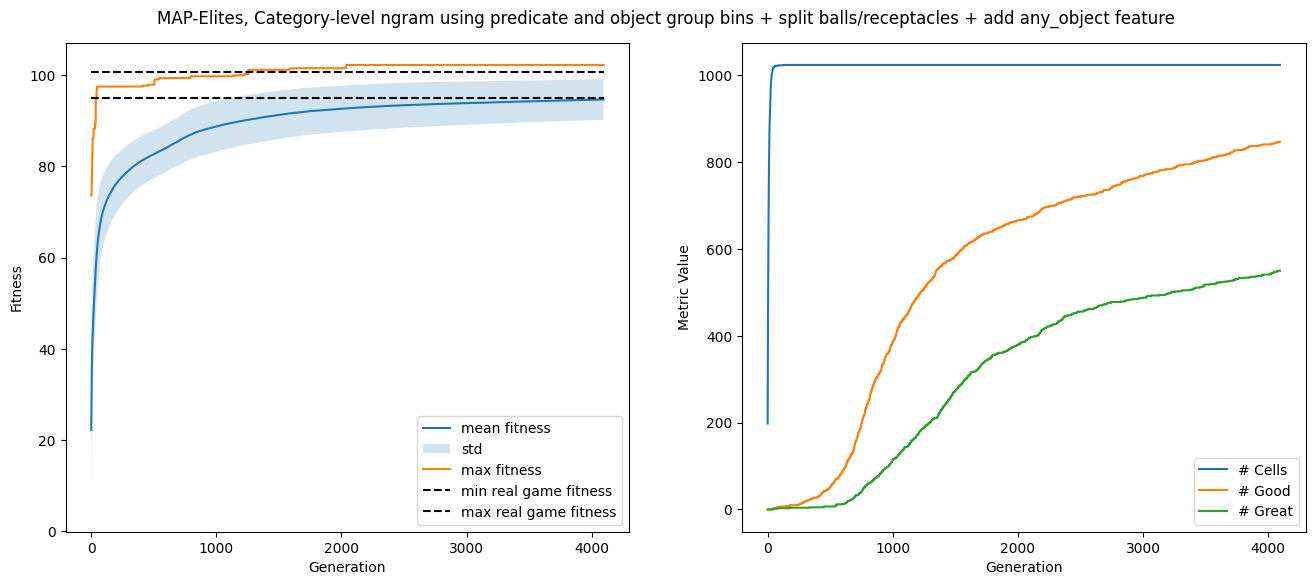

In [6]:
min_real_game_fitness = 95.1030 
max_real_game_fitness = 100.7051

predicate_and_object_groups_bb_go = typing.cast(MAPElitesSampler, utils.load_data('2023_08_11', 'samples', 'map_elites_longer_predicate_and_object_groups_bb_go_seed_33_final'))
plot_sampler_fitness_trajectory(predicate_and_object_groups_bb_go, 'MAP-Elites, Category-level ngram using predicate and object group bins + split balls/receptacles + add any_object feature',
                                min_real_game_fitness=min_real_game_fitness, max_real_game_fitness=max_real_game_fitness)

In [9]:
trace_filter_results = utils.load_data('2023_08_23', 'samples', 'trace_filter_results_map_elites_longer_predicate_and_object_groups_bb_go_seed_33_final_2023_08_11')
print(trace_filter_results.keys())
trace_filter_results_summary = trace_filter_results['summary']
trace_filter_results_full = trace_filter_results['full']

dict_keys(['summary', 'full'])


In [10]:
result_counts = Counter(trace_filter_results_summary.values())
for key in sorted(result_counts.keys()):
    print(f'{key}: {result_counts[key]}')

print(sum(v for k, v in result_counts.items() if k > 0))

-1: 29
0: 323
1: 106
2: 27
3: 27
4: 40
5: 472
672


In [26]:
zero_values_keys = [k for k, v in trace_filter_results_summary.items() if v == 0]
keys_by_value = defaultdict(list)
for k, v in trace_filter_results_summary.items():
    keys_by_value[v].append(k)

In [48]:
model = predicate_and_object_groups_bb_go
key =  keys_by_value[1][14]
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

print('Preference satisfaction counts:')
for preference_name in sorted(trace_filter_results_full[key]):
    preference_count = sum(trace_filter_results_full[key][preference_name].values())
    print(f'{preference_name}: {"**" if preference_count == 0 else ""}{preference_count}{"**" if preference_count == 0 else ""}')

print()
model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
sample = model.population[key] 

Preference satisfaction counts:
(:setup: 57
preference0: 101
preference1: 1
preference2: 13

Sample features for key (0, 1, 0, 1, 0, 1, 1, 1, 1, 1):
predicate_used_agent_holds|in_motion: 0
predicate_used_in: 1
predicate_used_on|touch: 0
predicate_used_adjacent|between: 1
object_category_used_balls: 0
object_category_used_receptacles: 1
object_category_used_blocks|building: 1
object_category_used_furniture|room_features: 1
object_category_used_small_objects|large_objects: 1
object_category_used_any_object: 1


### Energy of visualized game: -92.090

### Top features contributing to the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                        | Features decreasing energy (= more real)                                         |
|---------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| mean_depth_constraints_1: **1.332** = (1.000) * 1.332                           | ast_ngram_full_n_5_score: **-30.704** = (0.848) * -36.207                        |
| node_count_setup_2: **1.002** = (1.000) * 1.002                                 | ast_ngram_constraints_n_5_score: **-19.484** = (0.844) * -23.081                 |
| mean_depth_setup_3: **0.974** = (1.000) * 0.974                                 | ast_ngram_setup_n_5_score: **-10.365** = (0.947) * -10.940                       |
| max_depth_setup_3: **0.477** = (1.000) * 0.477                                  | ast_ngram_scoring_n_5_score: **-6.166** = (0.934) * -6.605                       |
| mean_depth_scoring_4: **0.354** = (1.000) * 0.354                               | variables_used_all: **-5.471** = (1.000) * -5.471                                |
| predicate_under_modal_at_end_in: **0.295** = (1.000) * 0.295                    | predicate_found_in_data_constraints_prop: **-5.067** = (1.000) * -5.067          |
| scoring_count_expression_repetitions_exist: **0.292** = (1.000) * 0.292         | preferences_used_all: **-4.886** = (1.000) * -4.886                              |
| max_depth_scoring_4: **0.271** = (1.000) * 0.271                                | variables_defined_all: **-1.887** = (1.000) * -1.887                             |
| in_arg_types_receptacles_large_objects_constraints: **0.262** = (1.000) * 0.262 | num_preferences_defined_3: **-1.403** = (1.000) * -1.403                         |
| adjacent_arg_types_receptacles_room_features_setup: **0.041** = (1.000) * 0.041 | node_count_terminal_0: **-0.994** = (1.000) * -0.994                             |
|                                                                                 | section_doesnt_exist_terminal: **-0.983** = (1.000) * -0.983                     |
|                                                                                 | in_arg_types_building_blocks_constraints: **-0.968** = (1.000) * -0.968          |
|                                                                                 | setup_objects_used: **-0.932** = (0.500) * -1.864                                |
|                                                                                 | max_quantification_count_constraints_1: **-0.928** = (1.000) * -0.928            |
|                                                                                 | node_count_scoring_3: **-0.902** = (1.000) * -0.902                              |
|                                                                                 | predicate_found_in_data_setup_prop: **-0.878** = (1.000) * -0.878                |
|                                                                                 | setup_quantified_objects_used: **-0.854** = (0.500) * -1.708                     |
|                                                                                 | max_depth_terminal_0: **-0.837** = (1.000) * -0.837                              |
|                                                                                 | max_number_variables_types_quantified_variables_1: **-0.827** = (1.000) * -0.827 |
|                                                                                 | mean_depth_terminal_0: **-0.825** = (1.000) * -0.825                             |

### Game:

```pddl
(define (game evo-4094-323-0) (:domain medium-objects-room-v1)
(:setup
  (and
    (exists (?v0 - hexagonal_bin)
      (game-conserved
        (not
          (exists (?v1 - wall)
            (adjacent ?v1 ?v0)
         )
       )
     )
   )
 )
)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - building ?v1 - (either cube_block pyramid_block))
        (at-end
          (and
            (in ?v0 ?v1)
         )
       )
     )
   )
    (preference preference1
      (exists (?v1 - pillow ?v2 - hexagonal_bin)
        (at-end
          (in ?v2 ?v1)
       )
     )
   )
    (preference preference2
      (exists (?v0 - game_object)
        (at-end
          (broken ?v0)
       )
     )
   )
 )
)
(:scoring
  (* 100 (count-once-per-objects preference0) (* 100 (count-once-per-objects preference0) (* 3 (count preference1))
      (* 4 (* 100 (count preference2) (* (- 2)
            (count preference0)
            2
            (* 100 (count-once-per-objects preference0) (* 3 (count-once-per-objects preference0))
              (* 4 (count-once-per-objects preference0))
           )
         )
          (* 4 (count-once-per-objects preference2))
       )
     )
   )
    (* 100 (count-once-per-objects preference0) (* 4 (count-once-per-objects preference0))
      (* 4 (count preference2))
   )
 )
)
)
```

In [41]:
preference_name = 'preference2'
{k: v for k, v in trace_filter_results_full[key][preference_name].items() if v > 0}

{'xMUrxzK3fXjgitdzPKsm-gameplay-attempt-1-rerecorded': 1}

In [53]:
model.samplers['prior2'].rules['predicate_or_function_location_term']['term']['token_posterior']

{'door': 0.06818181818181818,
 'desk': 0.2,
 'room_center': 0.14545454545454545,
 'bed': 0.08181818181818182,
 'agent': 0.004545454545454545,
 'green_golfball': 0.00909090909090909,
 'side_table': 0.00909090909090909,
 'rug': 0.01818181818181818,
 'east_sliding_door': 0.004545454545454545,
 'south_wall': 0.004545454545454545,
 'west_wall': 0.004545454545454545,
 'variable': 0.45}

In [57]:
model.samplers['prior2'].rules['side']

{'type_posterior': {'rule': 0.0, 'token': 1.0},
 'token_posterior': {'back': 0.2,
  'front': 0.2,
  'front_left_corner': 0.2,
  'left': 0.2,
  'right': 0.2},
 'production': (('token', 'SAMPLE'),)}

In [54]:
model.samplers['prior2'].rules['predicate_or_function_term']['term']['token_posterior']

{'agent': 0.06425233644859812,
 'top_drawer': 0.002336448598130841,
 'bed': 0.01985981308411215,
 'floor': 0.014018691588785047,
 'rug': 0.018107476635514017,
 'desk': 0.012266355140186916,
 'main_light_switch': 0.0005841121495327102,
 'desktop': 0.0005841121495327102,
 'west_wall': 0.0011682242990654205,
 'south_wall': 0.0005841121495327102,
 'side_table': 0.0011682242990654205,
 'green_golfball': 0.0011682242990654205,
 'bottom_shelf': 0.0005841121495327102,
 'top_shelf': 0.0029205607476635513,
 'pink': 0.0035046728971962616,
 'blue': 0.0029205607476635513,
 'brown': 0.002336448598130841,
 'green': 0.0011682242990654205,
 'tan': 0.0005841121495327102,
 'north_wall': 0.0005841121495327102,
 'variable': 0.8492990654205608}